In [3]:
# use pip to install pandas, matplotlib if needed
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from sklearn import set_config
from sklearn.model_selection import train_test_split
set_config(display="text")  # displays text representation of estimators

from utils import *
from runSurvModels import *

In [2]:
# prepare data
folder = 'linear'
keywords = ['exponential', 'orig']

train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords)

# Deep Learning Methods

When running different packages, different python environments might be needed. Therefore, we create virtual environments with varying python versions to avoid package version incompatibilities. The usual steps are as follows:


> venv/Scripts/activate

Or, if you are operating from a MacOS/Linux system:

> source venv/bin/activate

## DeepSurv
> git clone https://github.com/jaredleekatzman/DeepSurv.git \
> cd DeepSurv\
> pip install .

## DeepSurvK (Python v3.8+)
DeepSurvK is an adaptation of DeepSurv to deep NN training with Keras `Tensorflow` in later versions of python. It's also easier to install using the `pip` tool that comes with python installation. Here's how:

> pip install deepsurvk

## Cox-nnet

*NOTE: Cox-nnet requires python2.x which is currently deprecated. Due to dependency inavailability, we no longer consider including this method in the comparison.*

Using the bellow command lines to install the cox-nnet package (*Python version 2.7.* *)
> git clone https://github.com/lanagarmire/cox-nnet.git \
> cd cox-nnet \
> pip install . 

# Tree Methods

In [9]:
# prepare data
X_train, y_train = dataframe_to_scikitsurv_ds(train_df)
X_test, y_test = dataframe_to_scikitsurv_ds(test_df)

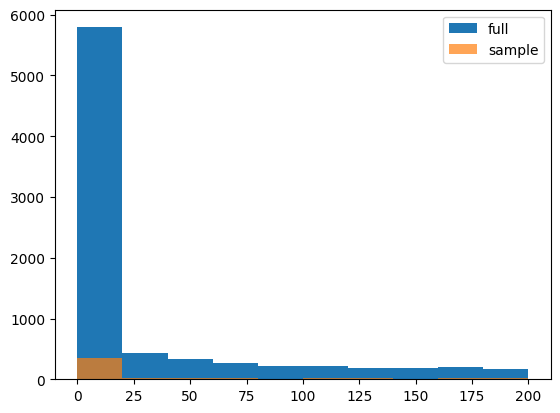

In [11]:
n = 500
xtrain,_, ytrain,_ = train_test_split(
    X_train, y_train,
    train_size=n/X_train.shape[0], 
    shuffle=True, random_state=42, stratify=[val[0] for val in y_train]
)
plt.hist([val[1] for val in y_train], label='full')
plt.hist([val[1] for val in ytrain], alpha=0.7, label='sample')
plt.legend()

In [42]:
class EarlyStoppingMonitor:
    def __init__(self, window_size, max_iter_without_improvement):
        self.window_size = window_size
        self.max_iter_without_improvement = max_iter_without_improvement
        self._best_step = -1

    def __call__(self, iteration, estimator, args):
        if iteration < self.window_size:
            return False

        # compute average improvement in last self.window_size iterations.
        # oob_improvement_ is the different in negative log partial likelihood
        # between the previous and current iteration.
        start = iteration - self.window_size + 1
        end = iteration + 1
        improvement = np.mean(estimator.oob_improvement_[start:end])

        if improvement > 1e-6:
            self._best_step = iteration
            return False  # continue fitting

        # stop fitting if there was no improvement
        # in last max_iter_without_improvement iterations
        diff = iteration - self._best_step
        return diff >= self.max_iter_without_improvement

# rsf_early_stopping = RandomSurvivalForest(
#     n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=42
# )

monitor = EarlyStoppingMonitor(10, 5)
# rsf_early_stopping.fit(X_train, y_train, monitor=monitor)

# print("Fitted base learners:", rsf_early_stopping.n_estimators_)

# cindex = rsf_early_stopping.score(X_test, y_test)
# print("Performance on test set", round(cindex, 3))

## Random Survival Forest

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score=0.5,
             estimator=RandomSurvivalForest(max_depth=3, n_estimators=500,
                                            n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'min_samples_leaf': [5, 15, 25],
                         'min_samples_split': [3, 10, 20]})

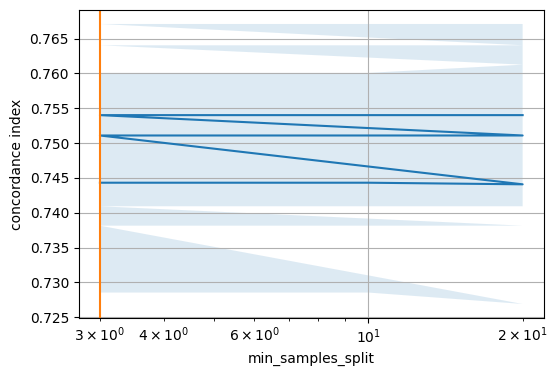

In [4]:
manual_hyperparameters = {
    # 'n_estimators': [100, 500,800],
    # 'max_depth': [3, 5, 7],
    'min_samples_split': [3,10,20],
    'min_samples_leaf': [5,15,25]
}
# parameters for fitting RSF models
kwargs = {
    'n_estimators':500,
    'max_depth': 3,
    # 'min_samples_split':10,
    # 'min_samples_leaf':15,
    'n_jobs':-1, 
    'random_state':42
}
rsf = RandomSurvivalForestModel(X_train[:1000], y_train[:1000], X_test, y_test,
                                hyperparameters=manual_hyperparameters)
rsf.build_model(**kwargs)
search = rsf.tune_hyperparameters(n_split=5, plotting_param='min_samples_split')
search

In [6]:
rsf.model

RandomSurvivalForest(max_depth=3, min_samples_leaf=25, min_samples_split=3,
                     n_estimators=500, n_jobs=-1, random_state=42)

In [12]:
# parameters for fitting RSF models
kwargs = {'n_estimators':500, 
          'min_samples_split':10,
        'min_samples_leaf':15,
        'n_jobs':-1, 
        'random_state':42}
rsf = RandomSurvivalForestModel(X_train, y_train, X_test, y_test, dataName='exponential-RW')
rsf.build_model(**kwargs)
rsf_results, rsf_dict = rsf.train(subset=[50,200,500,1000,2000,5000,8000])
rsf.write(rsf_dict)

# N=50 Training time (0.99s): Train C-Index: 0.756 | Test C-index: 0.63
# N=200 Training time (0.97s): Train C-Index: 0.842 | Test C-index: 0.747
# N=500 Training time (5.7s): Train C-Index: 0.865 | Test C-index: 0.782
# N=1000 Training time (28.69s): Train C-Index: 0.868 | Test C-index: 0.798
# N=2000 Training time (139.52s): Train C-Index: 0.878 | Test C-index: 0.815
# N=5000 Training time (1013.03s): Train C-Index: 0.884 | Test C-index: 0.829
# N=8000 Training time (2812.81s): Train C-Index: 0.888 | Test C-index: 0.837

# N=50 Training time (0.93s): Train C-Index: 0.796 | Test C-index: 0.615
# N=200 Training time (1.06s): Train C-Index: 0.851 | Test C-index: 0.733
# N=500 Training time (5.73s): Train C-Index: 0.885 | Test C-index: 0.809
# N=1000 Training time (26.79s): Train C-Index: 0.899 | Test C-index: 0.826
# N=2000 Training time (131.26s): Train C-Index: 0.9 | Test C-index: 0.842
# N=5000 Training time (960.17s): Train C-Index: 0.908 | Test C-index: 0.858
# N=8000 Training time (2648.21s): Train C-Index: 0.911 | Test C-index: 0.865

N=50 Training time (0.93s): Train C-Index: 0.796 | Test C-index: 0.615
N=200 Training time (1.06s): Train C-Index: 0.851 | Test C-index: 0.733
N=500 Training time (5.73s): Train C-Index: 0.885 | Test C-index: 0.809
N=1000 Training time (26.79s): Train C-Index: 0.899 | Test C-index: 0.826
N=2000 Training time (131.26s): Train C-Index: 0.9 | Test C-index: 0.842
N=5000 Training time (960.17s): Train C-Index: 0.908 | Test C-index: 0.858
N=8000 Training time (2648.21s): Train C-Index: 0.911 | Test C-index: 0.865


TypeError: join() argument must be str, bytes, or os.PathLike object, not 'NoneType'

## Gradient Boosting

In [8]:
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

In [9]:
est_early_stopping = GradientBoostingSurvivalAnalysis(
    n_estimators=1000, learning_rate=0.1, subsample=0.5, max_depth=1, random_state=0
)

monitor = EarlyStoppingMonitor(10, 5)

est_early_stopping.fit(X_train, y_train, monitor=monitor)

print("Fitted base learners:", est_early_stopping.n_estimators_)

cindex = est_early_stopping.score(X_test, y_test)
print("Performance on test set", round(cindex, 3))

NameError: name 'EarlyStoppingMonitor' is not defined

In [16]:
gb_kwargs = {
    'n_estimators':500, 
    # 'n_jobs':-1, 
    'random_state':42
}
gb_hyperparameters = {
    'learning_rate': [0.1, 0.9],
    'max_depth': [1, 5, 10]
}

gb =  GradientBoostingSurvivalModel(X_train[:500], y_train[:500], X_test, y_test,
                                    hyperparameters=gb_hyperparameters)
gb.build_model(**gb_kwargs)
gb_cv = gb.tune_hyperparameters(n_split=5)
pd.DataFrame(gb_cv.cv_results_)

/home/nfs/dengy/mind-crc-env/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:83: RuntimeWarning: overflow encountered in exp
  self.baseline_survival_ = StepFunction(uniq_times, np.exp(-y))
/home/nfs/dengy/mind-crc-env/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:83: RuntimeWarning: overflow encountered in exp
  self.baseline_survival_ = StepFunction(uniq_times, np.exp(-y))
/home/nfs/dengy/mind-crc-env/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:83: RuntimeWarning: overflow encountered in exp
  self.baseline_survival_ = StepFunction(uniq_times, np.exp(-y))
/home/nfs/dengy/mind-crc-env/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:83: RuntimeWarning: overflow encountered in exp
  self.baseline_survival_ = StepFunction(uniq_times, np.exp(-y))
/home/nfs/dengy/mind-crc-env/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:83: RuntimeWarning: overflow encountered in exp
  self.baseline_survival_ = StepFunction(uniq_times, np.exp(-y))


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,78.987563,0.940394,0.018028,0.028702,0.1,1,"{'learning_rate': 0.1, 'max_depth': 1}",0.830909,0.816364,0.804242,0.841818,0.822626,0.823192,0.012748,1
1,246.343846,4.950607,0.005623,0.000440,0.1,5,"{'learning_rate': 0.1, 'max_depth': 5}",0.810505,0.809899,0.789697,0.796768,0.790707,0.799515,0.009057,4
2,309.232191,4.486070,0.009736,0.000189,0.1,10,"{'learning_rate': 0.1, 'max_depth': 10}",0.748081,0.759192,0.746263,0.718384,0.754747,0.745333,0.014250,6
3,78.518984,1.109372,0.003462,0.000050,0.9,1,"{'learning_rate': 0.9, 'max_depth': 1}",0.811111,0.804040,0.812121,0.808485,0.807273,0.808606,0.002873,3
4,244.037484,6.315745,0.005808,0.000743,0.9,5,"{'learning_rate': 0.9, 'max_depth': 5}",0.827879,0.820202,0.809091,0.812121,0.806667,0.815192,0.007815,2
5,336.418411,25.017336,0.010486,0.000395,0.9,10,"{'learning_rate': 0.9, 'max_depth': 10}",0.767273,0.782828,0.763434,0.729495,0.754343,0.759475,0.017590,5


In [18]:
# parameters for fitting RSF models
kwargs = {'n_estimators':500, 
        'learning_rate':0.1,
        'max_depth':1,
        # 'n_jobs':-1, 
        'random_state':42}
gb = GradientBoostingSurvivalModel(X_train, y_train, X_test, y_test)
gb.build_model(**kwargs)
gb_results, gb_dict = gb.train(subset=[50,200,500,1000,2000,5000,8000])
gb.write(gb_dict)

# N=50 Training time (2.15s): Train C-Index: 0.996 | Test C-index: 0.685
# N=200 Training time (9.56s): Train C-Index: 0.944 | Test C-index: 0.785
# N=500 Training time (26.79s): Train C-Index: 0.91 | Test C-index: 0.808
# N=1000 Training time (60.01s): Train C-Index: 0.887 | Test C-index: 0.827
# N=2000 Training time (141.16s): Train C-Index: 0.873 | Test C-index: 0.837
# N=5000 Training time (488.76s): Train C-Index: 0.865 | Test C-index: 0.844

N=50 Training time (2.15s): Train C-Index: 0.996 | Test C-index: 0.685
N=200 Training time (9.56s): Train C-Index: 0.944 | Test C-index: 0.785
N=500 Training time (26.79s): Train C-Index: 0.91 | Test C-index: 0.808
N=1000 Training time (60.01s): Train C-Index: 0.887 | Test C-index: 0.827
N=2000 Training time (141.16s): Train C-Index: 0.873 | Test C-index: 0.837
N=5000 Training time (488.76s): Train C-Index: 0.865 | Test C-index: 0.844


In [17]:
%%time
random_state = 42
subset = [50, 200, 500, 1000, 2000, 5000, 8000]
gb_dict, gb_train_scores, gb_test_scores = {},{},{}
for n in subset:
    start = time.time()
    gb = GradientBoostingSurvivalAnalysis(
        n_estimators=500, learning_rate=0.1, max_depth=1, random_state=0
        ).fit(X_train[:n], y_train[:n])
    gb_dict[str(n)] = gb
    stop = time.time()
    duration = round(stop-start, 3)
    
    train_score = gb.score(X_train[:n], y_train[:n])
    gb_train_scores[str(n)] = train_score
    test_score = gb.score(X_test, y_test)
    gb_test_scores[str(n)] = test_score
        
    print(
        f'N={n} Training Time {duration}s:\tTrain C-Index: {train_score} | Test C-Index: {test_score}'
    )

Train C-Index: 0.9918367346938776	| Test C-Index: 0.7448410690579366
Train C-Index: 0.9416264090177133	| Test C-Index: 0.7726718933947849
Train C-Index: 0.8974929690638811	| Test C-Index: 0.789535355559452
Train C-Index: 0.8696315018755892	| Test C-Index: 0.7998797685544673
Train C-Index: 0.8456953526199313	| Test C-Index: 0.8047316083460662
Train C-Index: 0.8256932671453335	| Test C-Index: 0.807749918593292


# Baseline: CoxPH model

In [11]:
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sklearn.model_selection import GridSearchCV, KFold

### Hyperparameter Search

/tmp/ipykernel_377934/3934129116.py:1: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=1000).
  coxnet = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.001, max_iter=1000).fit(X_train, y_train)


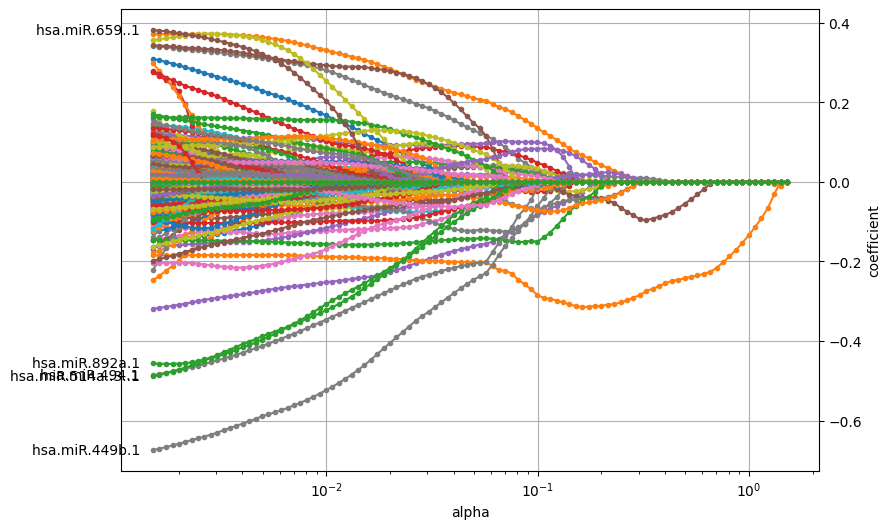

In [70]:
coxnet = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.001, max_iter=1000).fit(X_train, y_train)

coefficients = pd.DataFrame(coxnet.coef_, index=train_df.columns[:-2], columns=np.round(coxnet.alphas_, 5))
plot_coefficients(coefficients, n_highlight=5)

In [12]:
alphas =  [0.001,0.01,0.1] #coxnet.alphas_

coxnet_hyperparameters={
    "alphas": [[a] for a in alphas],
    'l1_ratio': [0.1, 0.9]
}
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test,
                            hyperparameters=coxnet_hyperparameters)
coxnet = build_model({''})

cv_results = pd.DataFrame(coxnet_cv.cv_results_)

In [13]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alphas,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,46.204700,1.347625,0.055914,0.001843,[0.001],0.1,"{'alphas': [0.001], 'l1_ratio': 0.1}",0.911458,0.905810,0.908276,0.910700,0.908393,0.908927,0.001999,4
1,42.287379,2.126294,0.056750,0.007874,[0.001],0.9,"{'alphas': [0.001], 'l1_ratio': 0.9}",0.915196,0.909837,0.912978,0.914337,0.911887,0.912847,0.001883,2
2,34.823239,2.155184,0.093512,0.008081,[0.01],0.1,"{'alphas': [0.01], 'l1_ratio': 0.1}",0.913515,0.907758,0.911669,0.914191,0.911716,0.911770,0.002237,3
3,29.688668,1.168285,0.124735,0.025512,[0.01],0.9,"{'alphas': [0.01], 'l1_ratio': 0.9}",0.918818,0.913556,0.917085,0.919981,0.916771,0.917242,0.002183,1
4,16.543225,2.392059,0.178689,0.029070,[0.1],0.1,"{'alphas': [0.1], 'l1_ratio': 0.1}",0.901618,0.895208,0.900865,0.904381,0.900726,0.900560,0.002983,5
5,1.755442,0.192350,0.242111,0.042911,[0.1],0.9,"{'alphas': [0.1], 'l1_ratio': 0.9}",0.866313,0.859564,0.870020,0.872047,0.861307,0.865850,0.004820,6


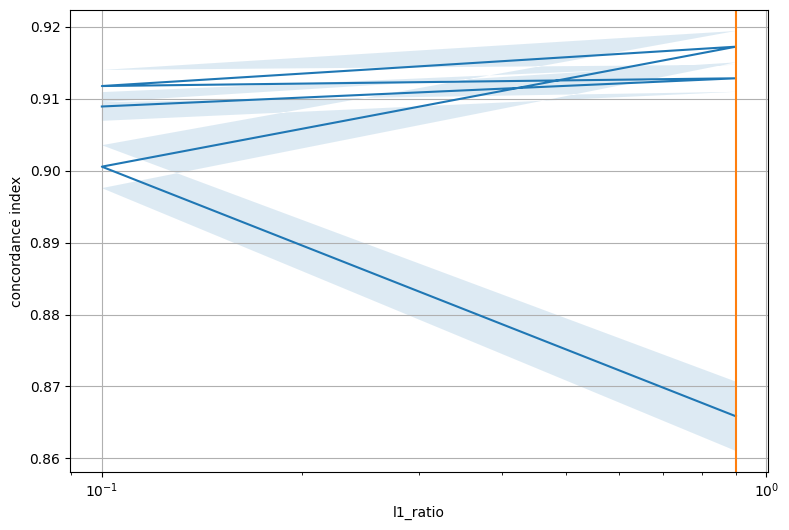

In [37]:
param = 'l1_ratio'
try:
    params = cv_results[f'param_{param}'].map(lambda x: x[0])
except TypeError:
    params = cv_results[f'param_{param}']
mean = cv_results.mean_test_score
std = cv_results.std_test_score


fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(params, mean)
ax.fill_between(params, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_xlabel(param)
ax.set_ylabel("concordance index")
ax.axvline(coxnet_cv.best_params_[param][0] 
            if isinstance(coxnet_cv.best_params_[param], list)
            else coxnet_cv.best_params_[param], 
        c="C1")
ax.grid(True)

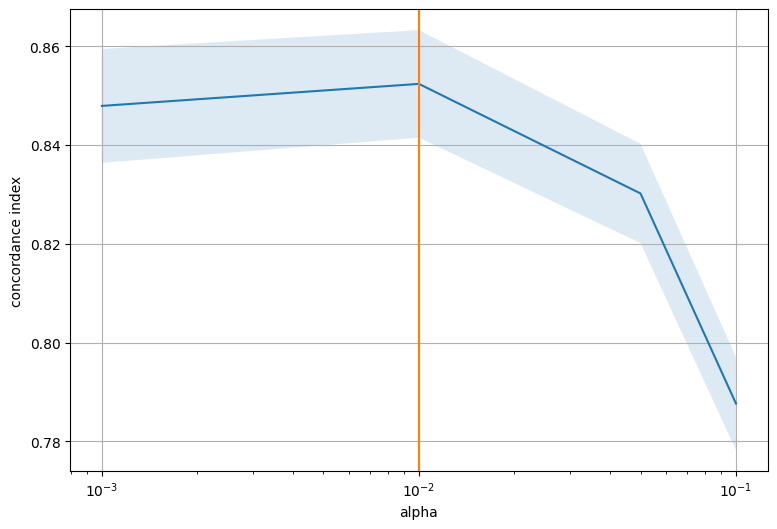

In [50]:
alphas = cv_results.param_alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(coxnet_cv.best_params_["alphas"][0], c="C1")
# ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

In [36]:
coxnet_cv.best_estimator_

CoxnetSurvivalAnalysis(alphas=[0.01], l1_ratio=0.9)

## Fitting model with best parameter

In [20]:
%%time
random_state = 42
subset = [50, 200, 500, 1000, 2000, 5000, 8000]

coxnet_dict, coxnet_train_scores, coxnet_test_scores = {},{},{}
for n in subset:
    start = time.time() #record iteration start time
    
    # train the forest with subset of training set
    coxnet = CoxnetSurvivalAnalysis(
        l1_ratio=0.9, alphas=[1e-2], max_iter=10000
    ).fit(X_train[:n], y_train[:n])

    stop = time.time() #Record time when training finished
    duration = round(stop - start, 2)
    
    train_sc = coxnet.score(X_train[:n], y_train[:n])
    test_sc = coxnet.score(X_test, y_test)
    print(f"N={n} Training time ({duration}s):\tTrain C-Index: {round(train_sc,3)} | Test C-index: {round(test_sc,3)}")
    
    coxnet_train_scores[str(n)] = train_sc
    coxnet_test_scores[str(n)] = test_sc
    coxnet_dict[str(n)] = coxnet


N=50 Training time (0.19s):	Train C-Index: 1.0 | Test C-index: 0.647
N=200 Training time (0.28s):	Train C-Index: 0.941 | Test C-index: 0.75
N=500 Training time (0.3s):	Train C-Index: 0.873 | Test C-index: 0.827
N=1000 Training time (0.68s):	Train C-Index: 0.864 | Test C-index: 0.841
N=2000 Training time (0.94s):	Train C-Index: 0.868 | Test C-index: 0.85
N=5000 Training time (2.04s):	Train C-Index: 0.856 | Test C-index: 0.853
N=8000 Training time (2.64s):	Train C-Index: 0.853 | Test C-index: 0.854
CPU times: user 8.2 s, sys: 55.8 ms, total: 8.26 s
Wall time: 8.21 s


In [39]:
# coxnet = CoxnetSurvivalAnalysis(l1_ratio=0.9, alphas=[1e-2], max_iter=10000)
# coxnet.fit(X_train, y_train)

In [14]:
coxnet.score(X_train, y_train)

0.8531652706588324

In [15]:
coxnet.score(X_test, y_test)

0.8536128064032016

Number of non-zero coefficients: 73


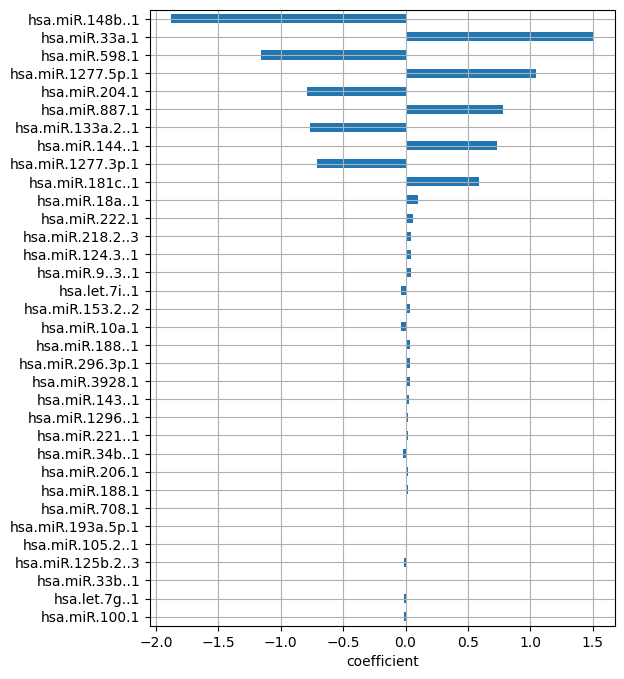

In [43]:

coefficients =  pd.DataFrame({'coefficient': [v[0] for v in coxnet.coef_]}, 
                            index=train_df.columns[:-3])
# coefficients[coefficients!=0]

non_zero = np.sum(coefficients.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = coefficients[abs(coefficients["coefficient"]) > 1e-2]
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

# Summarize Model Results

In [4]:
def load_simulate_results(dataFolderName, 
                        subset=[50, 200, 500, 1000, 2000, 5000, 8000],
                        modelnames=['coxnet','rsf','gb','deepsurvk']):
    
    results = pd.DataFrame({'n train': subset})
    for mdl in modelnames:
        file_dir = os.path.join('models', dataFolderName, mdl, 'model.results.txt')
        try:
            result_df = pd.read_table(file_dir, index_col=0)
        except:
            continue
        result_df.columns = ["_".join((col, mdl)) if col!='n train' else col for col in result_df.columns.tolist() ]
        results = results.merge(result_df, on='n train', how='outer')# right_on=result_df.columns[0])

    return results

In [5]:
subset = [50, 200, 500, 1000, 2000, 5000, 8000]
datanames = ['exponential','nl-1','nl-quadratic']
modelnames = ['coxnet','rsf','deepsurvk']

dt='exponential'
exp_results=load_simulate_results(dataFolderName=dt)
exp_results

,n train,train time_coxnet,train score_coxnet,test score_coxnet,train time_rsf,train score_rsf,test score_rsf,train time_gb,train score_gb,test score_gb,train time_deepsurvk,train score_deepsurvk,test score_deepsurvk
0,50,0.16,1.000000,0.792897,0.99,0.755918,0.630009,2.15,0.995918,0.685017,52.27,0.630702,0.566030
1,200,0.69,0.977715,0.905625,0.97,0.842412,0.747289,9.56,0.944271,0.784693,52.35,0.698326,0.700637
2,500,0.45,0.968304,0.947101,5.70,0.864537,0.781826,26.79,0.909812,0.807998,56.51,0.710868,0.720732
3,1000,0.55,0.963750,0.954088,28.69,0.867756,0.797550,60.01,0.887491,0.826810,64.30,0.780304,0.782060
4,2000,1.48,0.960912,0.956005,139.52,0.877710,0.814783,141.16,0.872569,0.836650,30.91,0.836958,0.835086
5,5000,7.50,0.960156,0.956580,1013.03,0.884463,0.829305,488.76,0.864669,0.844221,63.40,0.849962,0.845363
6,8000,10.72,0.959963,0.956931,2812.81,0.887637,0.837057,975.12,0.861003,0.847992,187.13,0.931415,0.925019


In [6]:
dt='exponential-RW'
exp_rw_results=load_simulate_results(dataFolderName=dt)
exp_rw_results

,n train,train time_coxnet,train score_coxnet,test score_coxnet,train time_rsf,train score_rsf,test score_rsf,train time_deepsurvk,train score_deepsurvk,test score_deepsurvk
0,50,0.30,0.938185,0.608279,1.00,0.806531,0.551547,28.35,0.648491,0.530087
1,200,0.76,0.664412,0.522215,1.13,0.811809,0.616865,48.39,0.627083,0.543020
2,500,0.12,0.762789,0.665842,5.60,0.799647,0.631967,53.47,0.599582,0.609931
3,1000,0.10,0.730195,0.692273,27.33,0.786120,0.636591,64.08,0.624458,0.599107
4,2000,0.16,0.709495,0.699435,125.82,0.789055,0.648396,47.34,0.648306,0.639103
5,5000,0.35,0.706730,0.710180,923.89,0.785062,0.652099,103.21,0.657822,0.652131
6,8000,0.79,0.710696,0.710413,2423.31,0.783061,0.657352,122.00,0.719661,0.707329


In [6]:
dt='nl-1'
nl_1_results = load_simulate_results(dataFolderName=dt)
nl_1_results

,n train,train time_coxnet,train score_coxnet,test score_coxnet,train time_gb,train score_gb,test score_gb,train time_deepsurvk,train score_deepsurvk,test score_deepsurvk
0,50,0.17,1.000000,0.795605,2.19,0.995918,0.693730,27.95,0.679510,0.597076
1,200,0.67,0.950789,0.855258,9.56,0.945126,0.793819,30.68,0.743510,0.727117
2,500,1.44,0.831623,0.747022,26.56,0.914333,0.827893,56.58,0.703997,0.694214
3,1000,1.07,0.964137,0.958133,NaN,NaN,NaN,56.76,0.688974,0.693997
4,2000,1.27,0.961332,0.958252,NaN,NaN,NaN,103.80,0.786103,0.789299
5,5000,4.94,0.959629,0.958736,NaN,NaN,NaN,71.94,0.850623,0.847316
6,8000,7.67,0.959879,0.959068,NaN,NaN,NaN,105.90,0.926791,0.921268


In [7]:
dt='nl-1-RW'
nl_1_rw_results = load_simulate_results(dataFolderName=dt)
nl_1_rw_results

,n train,train time_coxnet,train score_coxnet,test score_coxnet,train time_rsf,train score_rsf,test score_rsf,train time_gb,train score_gb,test score_gb,train time_deepsurvk,train score_deepsurvk,test score_deepsurvk
0,50,0.19,1.000000,0.682448,0.83,0.797,0.701,2.15,0.998099,0.692581,39.34,0.669452,0.626868
1,200,0.33,0.919127,0.736661,0.81,0.804,0.750,9.68,0.926009,0.755360,58.09,0.601454,0.584086
2,500,0.15,0.841966,0.774269,4.74,0.824,0.762,26.79,0.871379,0.770846,56.03,0.625675,0.609681
3,1000,0.18,0.811283,0.789215,22.32,0.829,0.764,60.16,0.838416,0.772665,55.96,0.609238,0.590735
4,2000,0.35,0.799595,0.795940,103.75,0.831,0.770,142.34,0.813307,0.781392,78.82,0.657134,0.639897
5,5000,0.92,0.794881,0.800621,802.51,0.834,0.778,499.89,0.797460,0.787981,61.36,0.755305,0.754400
6,8000,1.47,0.796275,0.800956,NaN,NaN,NaN,NaN,NaN,NaN,99.01,0.794917,0.794565


In [9]:
datanames = ['exponential','nl-1','nl-quadratic','nl-sine']
modelnames = ['coxnet','rsf','deepsurvk']

results = pd.DataFrame({'n train': subset})
for name in datanames:
    file_dir = os.path.join('models', name + "-RW", 'deepsurvk', 'model.results.1004.txt')
    try:
        result_df = pd.read_table(file_dir, index_col=0)
    except:
        continue
    result_df.columns = ["_".join((col, name)) if col!='n train' else col for col in result_df.columns.tolist() ]
    results = results.merge(result_df, on='n train', how='outer')# right_on=result_df.columns[0])

results

,n train,train time_exponential,train score_exponential,test score_exponential,train time_nl-1,train score_nl-1,test score_nl-1,train time_nl-quadratic,train score_nl-quadratic,test score_nl-quadratic,train time_nl-sine,train score_nl-sine,test score_nl-sine
0,50,27.71,0.636538,0.549257,32.67,0.675447,0.551707,11.41,0.624210,0.570508,21.84,0.615814,0.543267
1,200,38.81,0.626551,0.577943,56.69,0.625328,0.533050,32.07,0.713777,0.672707,56.37,0.667003,0.548472
2,500,6.97,0.603043,0.592067,60.92,0.656407,0.632522,67.30,0.757594,0.728853,58.55,0.646353,0.594889
3,1000,37.97,0.654404,0.631076,48.19,0.664571,0.650008,57.54,0.768258,0.739167,24.42,0.632241,0.621040
4,2000,90.48,0.676001,0.629131,86.23,0.681711,0.652148,49.28,0.802169,0.772843,106.58,0.672691,0.646547
5,5000,110.03,0.681048,0.659199,83.79,0.734216,0.716047,146.68,0.785191,0.769641,302.14,0.704032,0.680301
6,8000,117.10,0.711768,0.684835,245.97,0.765771,0.740702,295.92,0.861367,0.841314,361.45,0.785995,0.762024


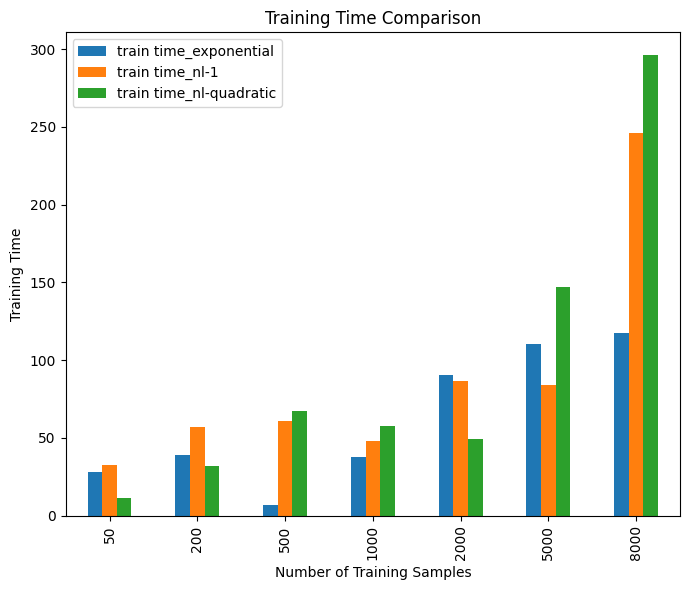

In [14]:
# Plotting
fig, ax = plt.subplots( figsize=(7, 6))

# Plot train time comparison
results.plot(x='n train', y=['train time_exponential', 'train time_nl-1', 'train time_nl-quadratic'], kind='bar', ax=ax)
ax.set_title('Training Time Comparison')
ax.set_ylabel('Training Time')
ax.set_xlabel('Number of Training Samples')


plt.tight_layout()
plt.show()

In [15]:
results.loc[:, [col for col in results.columns if ]]

,n train,train time_exponential,train score_exponential,test score_exponential,train time_nl-1,train score_nl-1,test score_nl-1,train time_nl-quadratic,train score_nl-quadratic,test score_nl-quadratic,train time_nl-sine,train score_nl-sine,test score_nl-sine
0,50,27.71,0.636538,0.549257,32.67,0.675447,0.551707,11.41,0.624210,0.570508,21.84,0.615814,0.543267
1,200,38.81,0.626551,0.577943,56.69,0.625328,0.533050,32.07,0.713777,0.672707,56.37,0.667003,0.548472
2,500,6.97,0.603043,0.592067,60.92,0.656407,0.632522,67.30,0.757594,0.728853,58.55,0.646353,0.594889
3,1000,37.97,0.654404,0.631076,48.19,0.664571,0.650008,57.54,0.768258,0.739167,24.42,0.632241,0.621040
4,2000,90.48,0.676001,0.629131,86.23,0.681711,0.652148,49.28,0.802169,0.772843,106.58,0.672691,0.646547
5,5000,110.03,0.681048,0.659199,83.79,0.734216,0.716047,146.68,0.785191,0.769641,302.14,0.704032,0.680301
6,8000,117.10,0.711768,0.684835,245.97,0.765771,0.740702,295.92,0.861367,0.841314,361.45,0.785995,0.762024


Text(0.5, 0, 'Number of Training Samples')

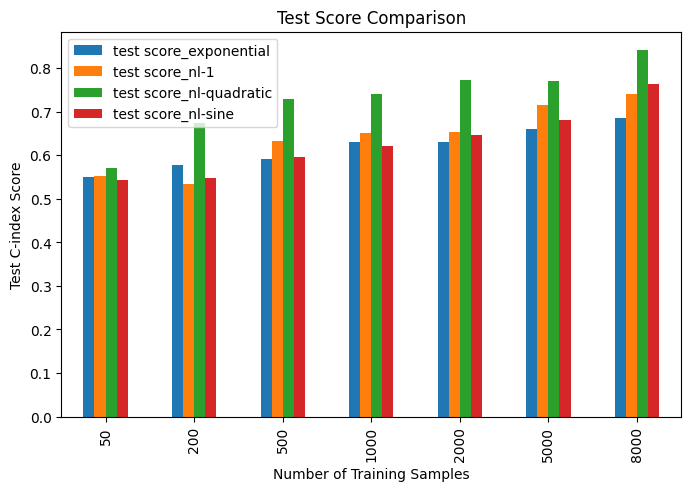

In [19]:
fig, ax = plt.subplots(figsize=(8, 5))

# Plot test scores comparison
results.plot(x='n train', y=['test score_exponential', 'test score_nl-1', 'test score_nl-quadratic', 'test score_nl-sine'], kind='bar', ax=ax)
ax.set_title('Test Score Comparison')
ax.set_ylabel('Test C-index Score')
ax.set_xlabel('Number of Training Samples')


# Archive

In [ ]:
%%time
random_state = 42
subset = [50, 200, 500, 1000, 2000, 5000, 8000]
rsf_dict, rsf_train_scores, rsf_test_scores = {},{},{}

for n in subset:
    start = time.time() #record iteration start time
    
    # train the forest with subset of training set
    rsf = RandomSurvivalForest(
        n_estimators=500, 
        min_samples_split=10, 
        min_samples_leaf=15, 
        n_jobs=-1, random_state=random_state
    ).fit(X_train[:n], y_train[:n])

    stop = time.time() #Record time when training finished
    duration = round(stop - start, 2)
    
    train_sc = rsf.score(X_train[:n], y_train[:n])
    test_sc = rsf.score(X_test, y_test)
    print(f"N={n} Training time ({duration}s): Train C-Index: {round(train_sc,3)} | Test C-index: {round(test_sc,3)}")
    
    rsf_train_scores[str(n)] = train_sc
    rsf_test_scores[str(n)] = test_sc
    rsf_dict[str(n)] = rsf
    
#### OLD Scores
# 0.7567028514257128
# 0.8131055527763882
# 0.8276813406703352
# 0.8504412206103051
# 0.8567188594297148

N=50 Training time (1.67s): Train C-Index: 0.8179591836734694 | Test C-index: 0.6269144572286143
N=200 Training time (1.38s): Train C-Index: 0.8337688442211055 | Test C-index: 0.7161860930465233
N=500 Training time (5.23s): Train C-Index: 0.8278396793587174 | Test C-index: 0.7333466733366684
N=1000 Training time (24.26s): Train C-Index: 0.8331131131131131 | Test C-index: 0.7506423211605803
N=2000 Training time (119.71s): Train C-Index: 0.8352256128064032 | Test C-index: 0.7543821910955478
N=5000 Training time (848.3s): Train C-Index: 0.8323171034206841 | Test C-index: 0.7683871935967984
N=8000 Training time (2315.39s): Train C-Index: 0.8329373984248031 | Test C-index: 0.7732251125562781
CPU times: user 7h 33min 37s, sys: 6min 30s, total: 7h 40min 7s
Wall time: 58min 2s
